# Twitter Network Analysis
This notebook contains a social network analysis mainly executed with the library of NetworkX. In detail, this dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks. The dataset can be found at this link: [Stanford Twitter Dataset](https://snap.stanford.edu/data/ego-Twitter.html).

## Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [2]:
twitter = pd.read_csv(
    "https://snap.stanford.edu/data/twitter_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
twitter = twitter.iloc[:80000]

The graph is created from the `twitter` dataframe of the edges:

In [3]:
G = nx.from_pandas_edgelist(twitter, "start_node", "end_node")

## Visualizing the graph

Let's start our exploration by visualizing the graph. Visualization plays a
central role in exploratory data analysis to help get a qualitative feel for
the data.

Since we don't have any real sense of structure in the data, let's start by
viewing the graph with `random_layout`, which is among the fastest of the layout
functions.

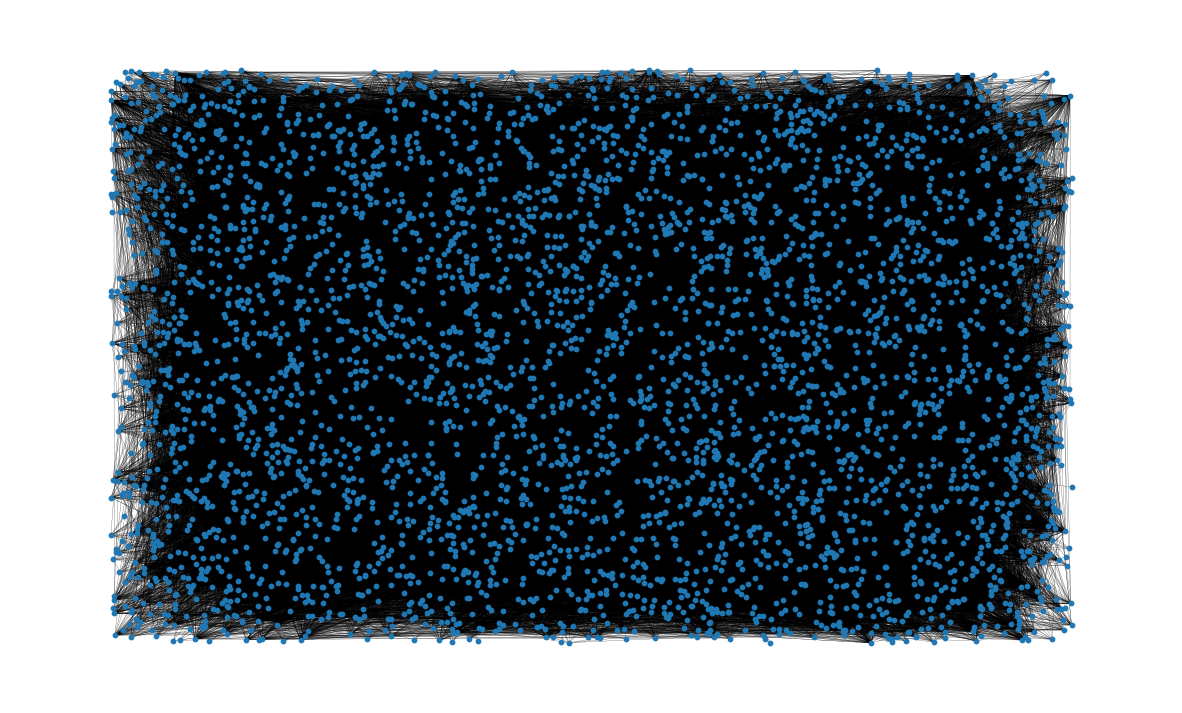

In [4]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Do we need more or less information (nodes or edges) from the graph to do the analysis? Let's check `spring_layout` and continue analysis...

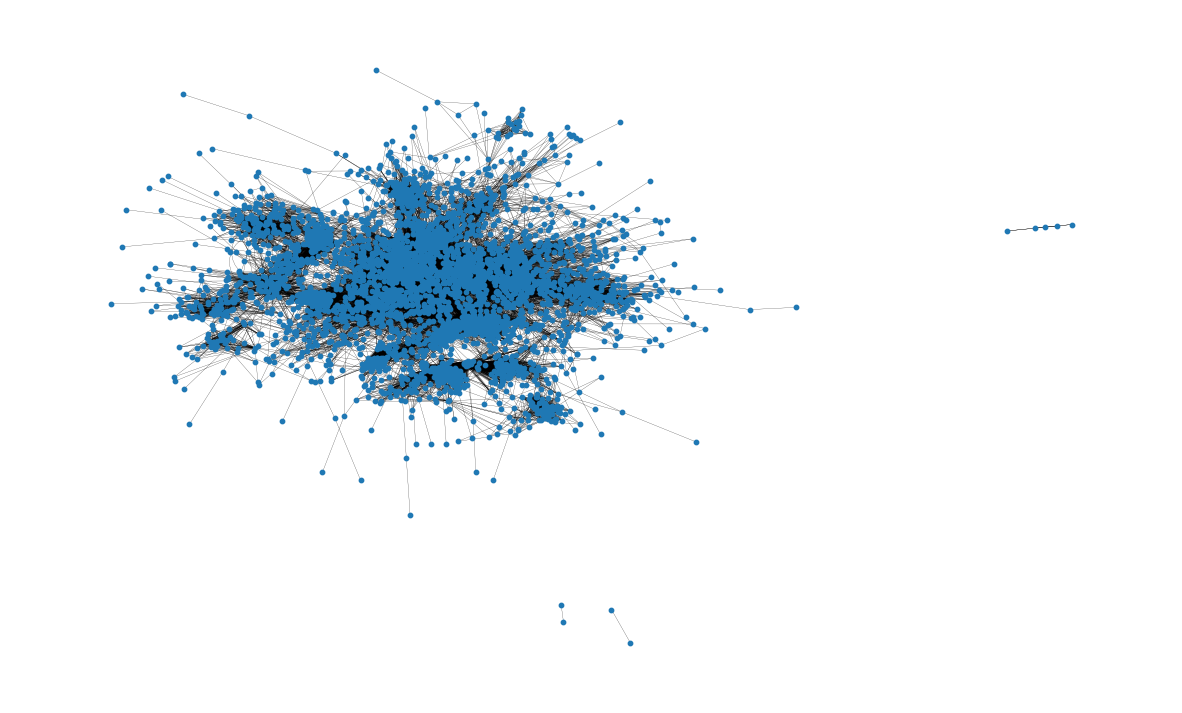

In [5]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

What other information can we extract from this network? ... (check graphs metrics)

## Basic topological attributes
Total number of nodes in network:

In [ ]:
G.number_of_nodes()

4316

Total number of edges:

In [ ]:
G.number_of_edges()

58270

Average degree of a node:

In [ ]:
np.mean([d for _, d in G.degree()])

27.00185356811863

Shortest path length for all pairs of nodes in the
network:

In [ ]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [ ]:
print(shortest_path_lengths.keys())  # Muestra las claves principales del diccionario

dict_keys([214328887, 34428380, 17116707, 28465635, 380580781, 18996905, 221036078, 153460275, 107830991, 17868918, 151338729, 222261763, 19705747, 88323281, 19933035, 149538028, 158419434, 17434613, 153226312, 364971269, 100581193, 279787626, 113058991, 69592091, 187773078, 406628822, 262802533, 460282402, 280935165, 437804658, 27633075, 285312927, 131613362, 17675120, 394263193, 254839786, 204317520, 21548772, 67864340, 172883064, 270449528, 297801196, 8088112, 14925700, 124528830, 307458983, 160237722, 220368467, 54228724, 206923844, 103598216, 207594668, 21146135, 451250774, 314316607, 6581292, 31331740, 196327549, 225444667, 274153775, 35415466, 72818790, 324201646, 40981798, 430268163, 88097807, 276308596, 358775055, 15023872, 16870853, 70492333, 430313102, 299715516, 35359596, 276577539, 248883350, 157829215, 107511013, 22462180, 258140947, 200559228, 19493072, 123371682, 461410856, 31414569, 37699718, 117901353, 117674417, 231238695, 56860418, 43003845, 413275344, 259842341, 40

In [ ]:
shortest_path_lengths[17675120][28465635]  # Length of shortest path between nodes 2 and 20

2

Verified if the graph is fully connected

In [ ]:
print(nx.is_connected(G))  # Esto devolverá True si el grafo está conectado, de lo contrario False

False


In [ ]:
# Encontrar la componente más grande
largest_cc = max(nx.connected_components(G), key=len)
# Crear un subgrafo con la componente más grande
G_largest = G.subgraph(largest_cc)

Diameter of the graph

In [ ]:
diameter = max(nx.eccentricity(G_largest, sp=shortest_path_lengths).values())
print(diameter)

16


In order to connect from one node to any other one we would have to traverse 16
edges or fewer.

Next up, the average path length is found.
Again, we could use `nx.average_shortest_path_length` to compute this
directly, but it's much more efficient to use the `shortest_path_length` that
we've already computed:

In [ ]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

4.837700405033223

This represents the average of the shortest path length for all pairs of nodes:
in order to reach from one node to another node, roughly 4.8 edges will be
traversed on average.

Visualization of the distribution of shortest path
lengths from our pre-computed dict-of-dicts:

Text(0, 0.5, 'Frequency (%)')

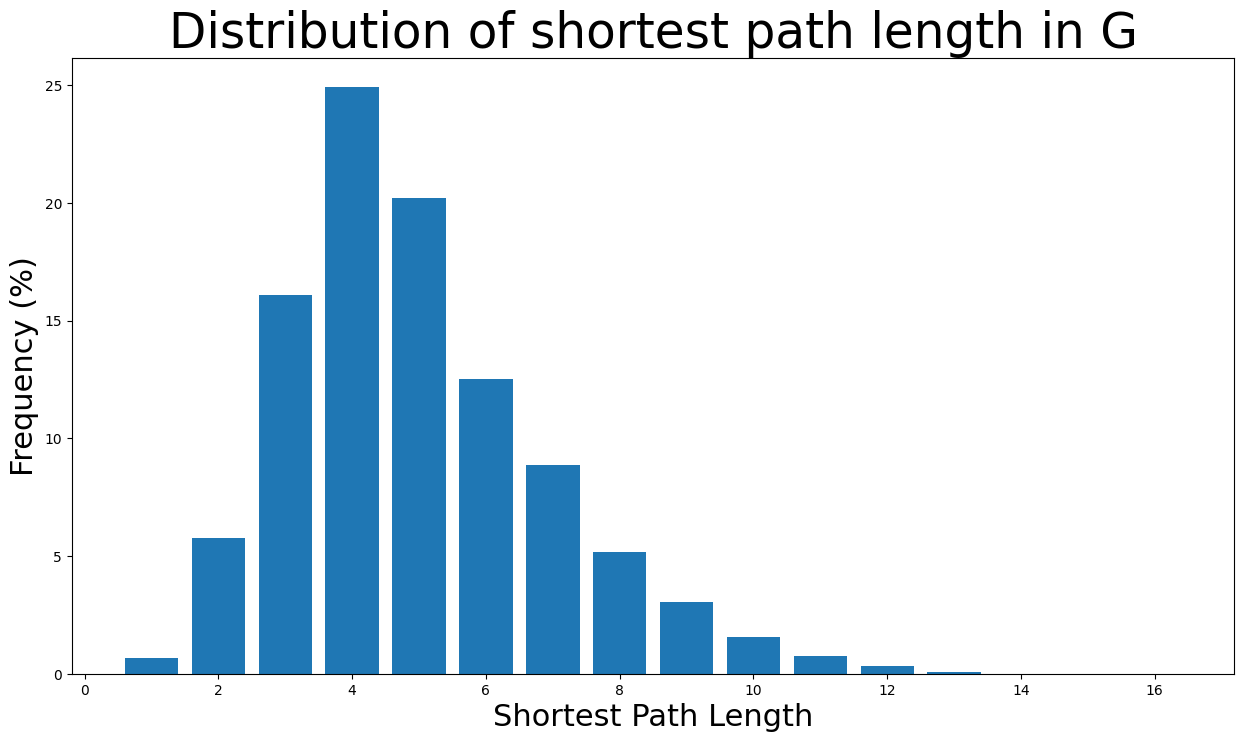

In [ ]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

The majority of the shortest path lengths are from $3$ to $5$ edges long.
Also, it's highly unlikely for a pair of nodes to have a shortest path of length 16 (diameter length) as the likelihood is less than $0.1$%.

The graph's density is calculated here. Clearly, the graph is a very sparse one as: $density < 1$

In [ ]:
nx.density(G)

0.0062576717423218145

The graph's number of components are found below. The network consists of seven giant components:

In [ ]:
nx.number_connected_components(G)

7

## Centrality measures
Now the centrality measures will be examined for the twitter graph

### Degree Centrality
Starting, we find the nodes with the highest degree centralities. Specifically, the nodes with the 8 highest degree centralities are shown below together with the degree centrality:

In [ ]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(48485771, 0.07022016222479723),
 (5442012, 0.06813441483198146),
 (3359851, 0.06581691772885284),
 (40981798, 0.06257242178447277),
 (43003845, 0.0593279258400927),
 (34428380, 0.056315179606025494),
 (22462180, 0.05608342989571263),
 (15913, 0.055851680185399766)]

That means that node $48485771$ has the highest degree centrality with $0.07022016222479723$, meaning that this twitter user is friend with around the 7% of the whole network. Similarly, nodes $5442012, 3359851$ and $40981798$ also have very high degree centralities.

Now we can also see the number of neighbors for the nodes with the highest degree centralities:

In [ ]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(48485771, 303),
 (5442012, 294),
 (3359851, 284),
 (40981798, 270),
 (43003845, 256),
 (34428380, 243),
 (22462180, 242),
 (15913, 241)]

As expected, node $48485771$ has $303$ twitter friends which is the most any twitter user has in this analysis.

Now the distribution of degree centralities will be plotted:

Text(0, 0.5, 'Counts')

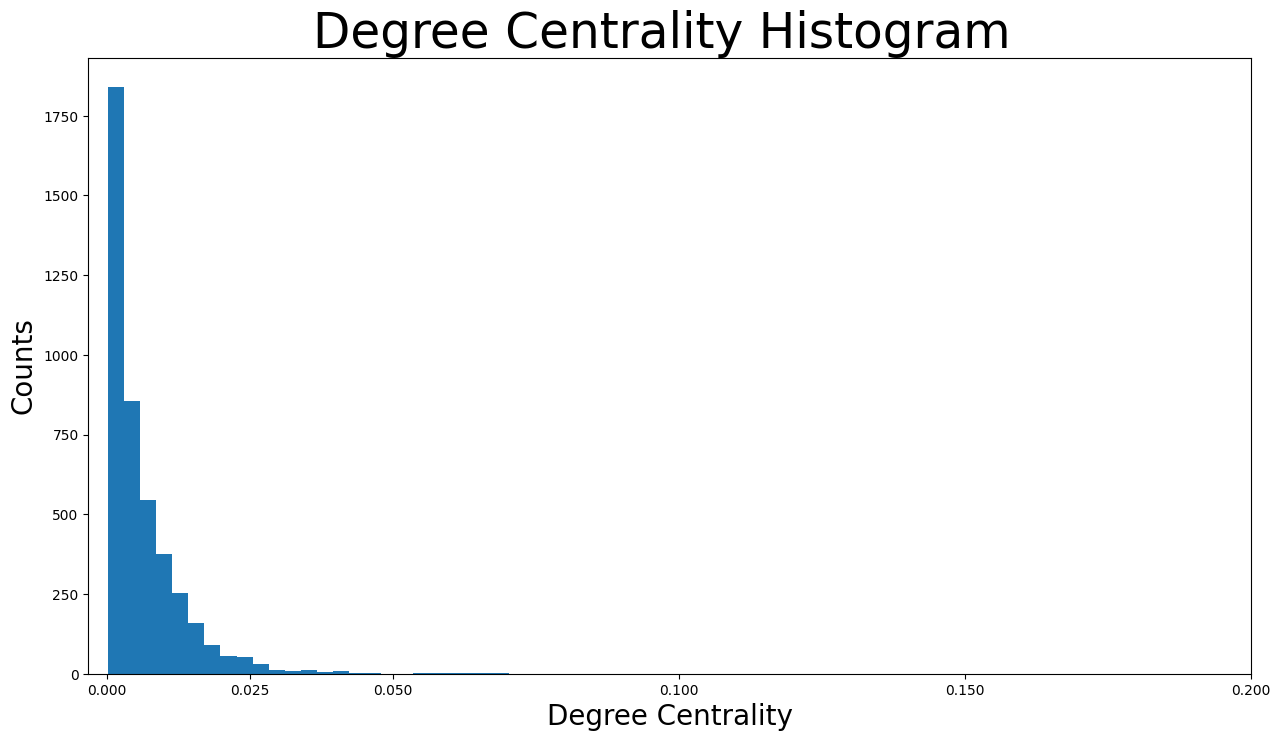

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

It is visible that the vast majority of twitter users have degree centralities of less than $0.05$. In fact the majority has less than $0.025$. Actually, that makes sense because the network consists of friends lists of particular nodes, which are obviously the ones with the highest degree centralities. In other words, because only the friends list of particular nodes were used to create this particular network, plenty of nodes have extremely low degree centralities as they are not very interconnected in this network

Now let's check the users with highest degree centralities from the size of their nodes:

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

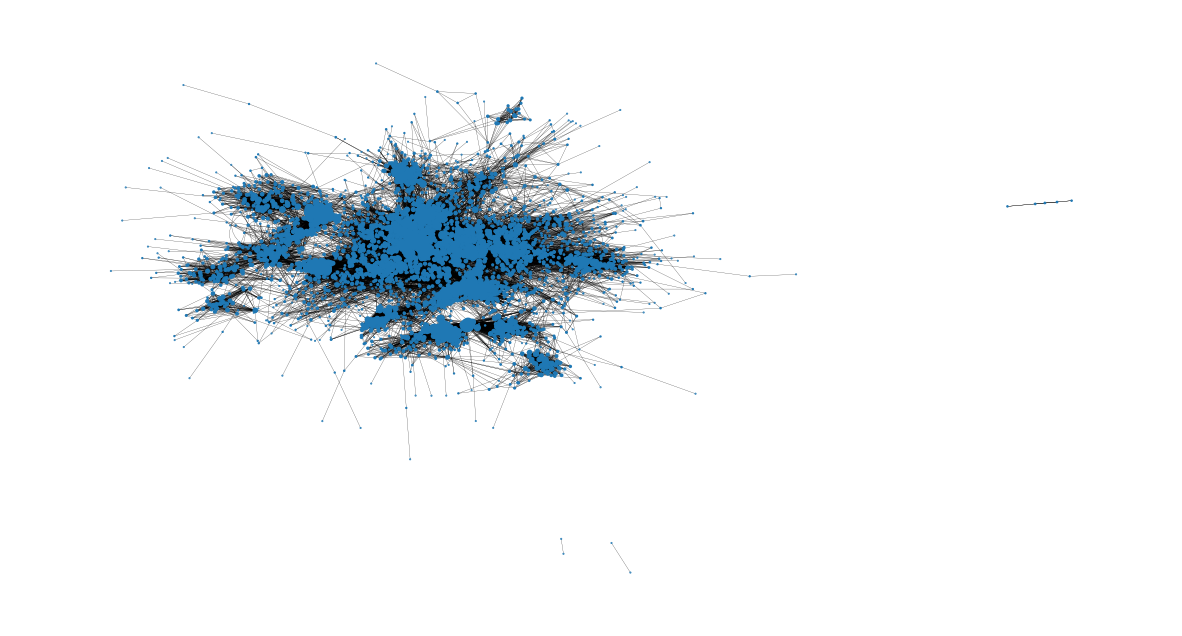

In [ ]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Betweenness Centrality
Betweenness centrality measures the number of times a node lies on the shortest path between other nodes, meaning it acts as a bridge. In detail, betweenness centrality of a node $v$ is the percentage of all the shortest paths of any two nodes (apart from $v$), which pass through $v$. Specifically, in the facebook graph this measure is associated with the user's ability to influence others. A user with a high betweenness centrality acts as a bridge to many users that are not friends and thus has the ability to influence them by conveying information (e.g. by posting something or sharing a post) or even connect them via the user's circle (which would reduce the user's betweeness centrality after).
* Now, the nodes with the $8$ highest betweenness centralities will be calculated and shown with their centrality values:

In [ ]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)  # save results in a variable to use again
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(6207392, 0.1725645640056724),
 (3359851, 0.15443758920551148),
 (783214, 0.0975291202117271),
 (41716273, 0.09272687817377762),
 (17093617, 0.09073724589851986),
 (27634404, 0.08587007531097253),
 (15666380, 0.07953763787324364),
 (48485771, 0.05738734697388068)]

Looking at the results, the node $6207392$ has a betweenness centrality of $0.17$, meaning it lies on almost half of the total shortest paths between other nodes. Also, combining the knowledge of the degree centrality:

Moving on, the distribution of betweenness centralities will be plotted:

Text(0, 0.5, 'Counts')

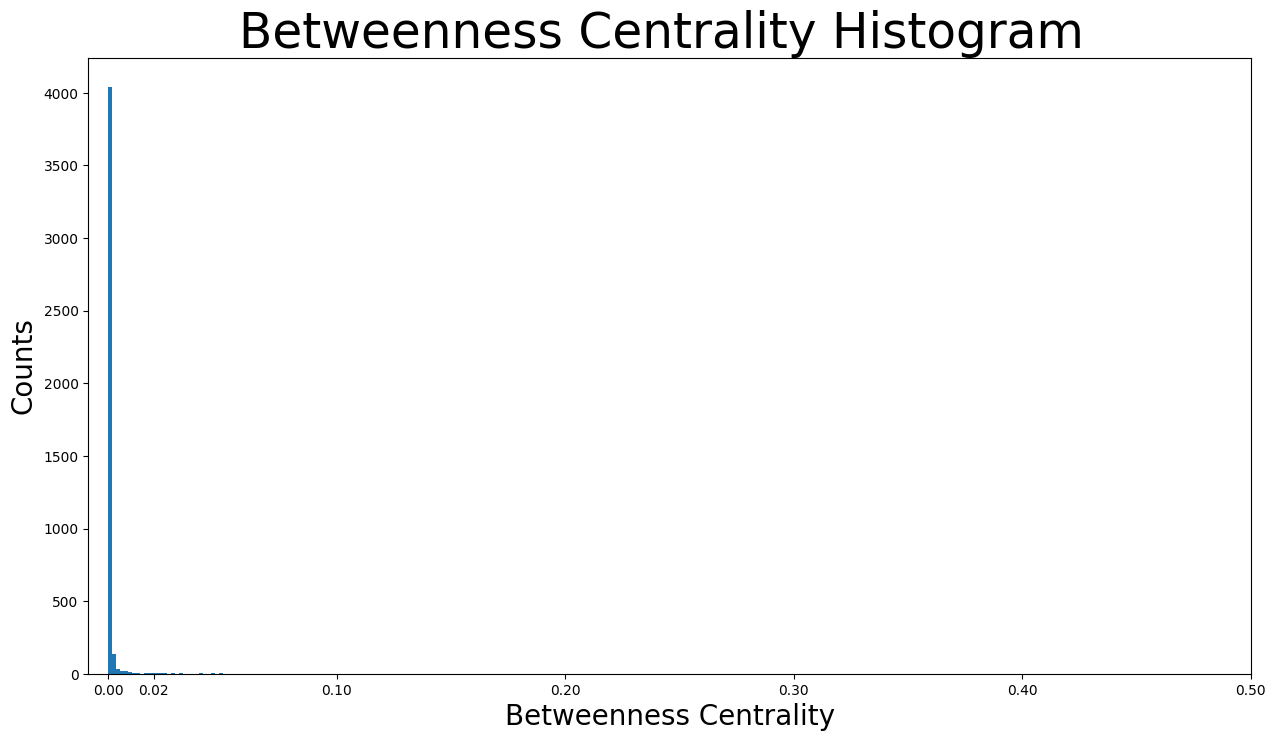

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

As we can see, the vast majority of betweenness centralities is below $0.02$. That makes sense as the graph is very sparse and thus most nodes do not act as bridges in shortest paths.

We can also get an image on the nodes with the highest betweenness centralities and where they are located in the network. It is clear that they are the bridges from one community to another:

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

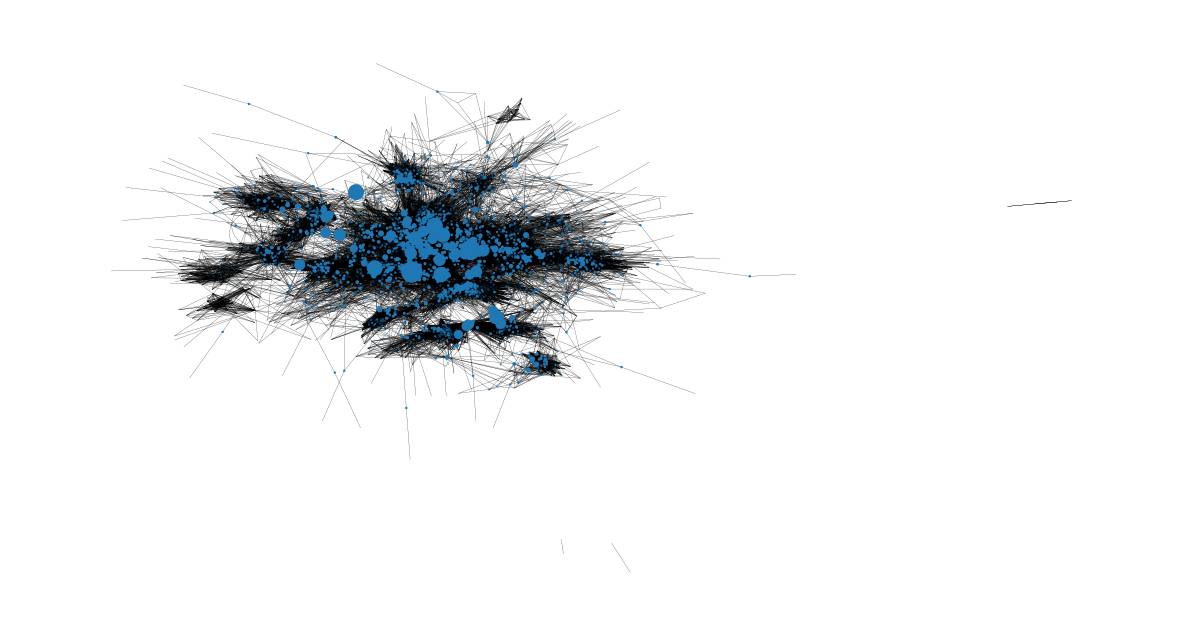

In [ ]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Closeness Centrality

Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network. For a node $v$, its closeness centrality measures the average farness to all other nodes. In other words, the higher the closeness centrality of $v$, the closer it is located to the center of the network.

The nodes with the highest closeness centralities will be found now:

In [6]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(3359851, 0.3174907000782523),
 (15234657, 0.2989200839846593),
 (48485771, 0.2947102540271258),
 (7860742, 0.293730499193259),
 (15666380, 0.2907448655999966),
 (20880546, 0.29061735524303445),
 (3829151, 0.2868847706962951),
 (115485051, 0.2850950836856413)]

Inspecting the users with the highest closeness centralities, we understand that there is not a huge gap between them in contrast to the previous metrics. Also, the nodes $3359851, 15234657, 48485771$ are the only `spotlight nodes` found in the ones with the highest closeness centralities. That means that a node that has many friends is not necessary close to the center of the network.

Also, the average distance of a particular node $v$ to any other node can be found easily with the formula:

$$\frac{1}{closeness\,centrality(v)}$$

In [7]:
1 / closeness_centrality[3359851]

3.149698557323187

The distance from node $3359851$ to a random node is around three hops


Furthermore, the distribution of the closeness centralities:

Text(0, 0.5, 'Counts')

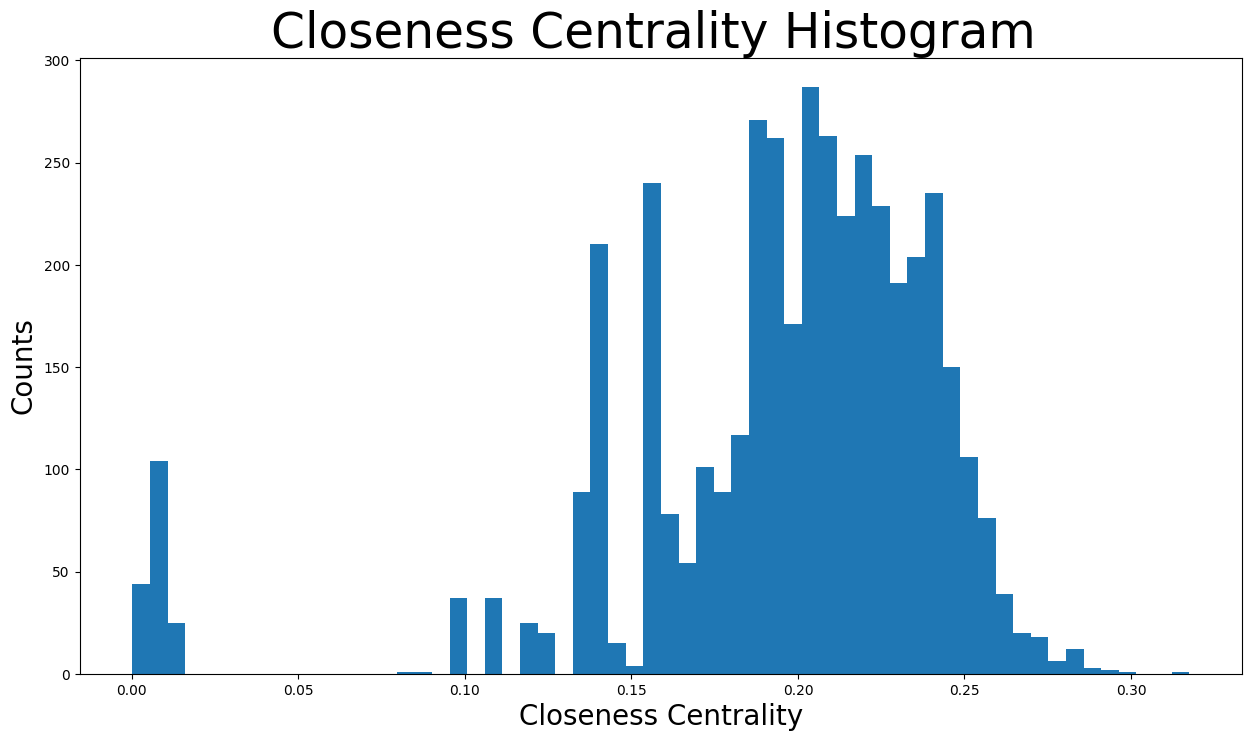

In [8]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

The closeness centralities are distributed over various values from $0.17$ to $0.25$. In fact, the majority of them are found between $0.22$ and $0.24$. That means that the majority of nodes are relatively close to the center of the network and thus close to other nodes in general. However, there are some communities that are located further away, whose nodes would have the minimum closeness centralities, as seen below:

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

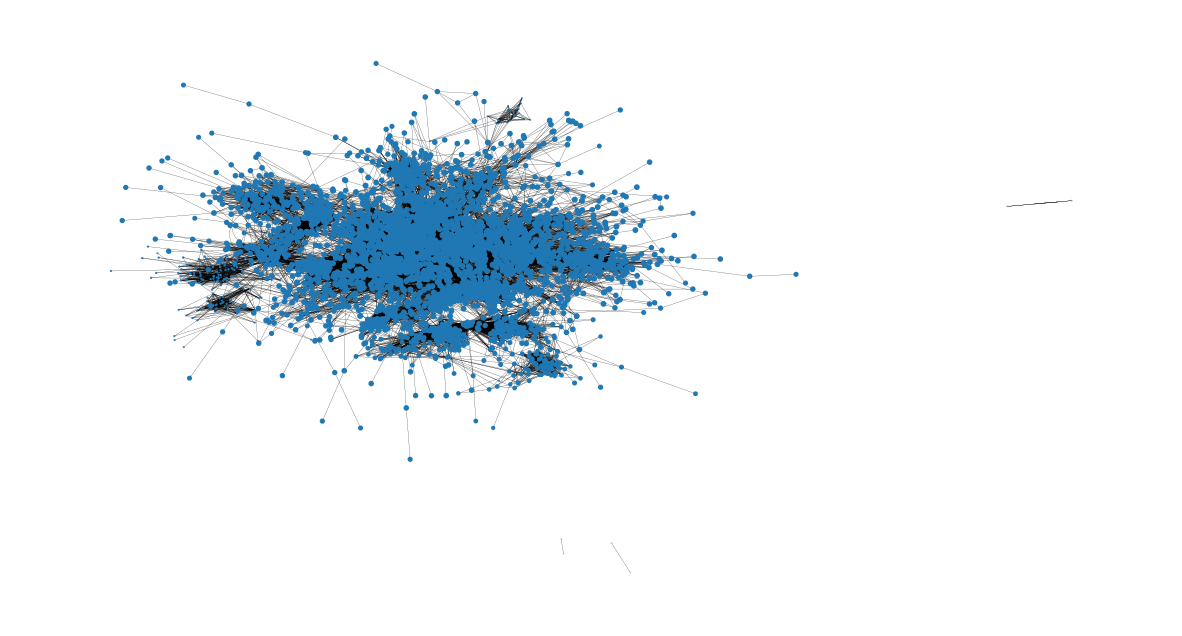

In [9]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Eigenvector Centrality

Eigenvector centrality is the metric to show how connected a node is to other important nodes in the network. It measures a node's influence based on how well it is connected inside the network and how many links its connections have and so on.

The nodes with the highest eigenvector centralities will be examined now:

In [10]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
)  # save results in a variable to use again
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(40981798, 0.15363590744821665),
 (43003845, 0.1507372702636457),
 (22462180, 0.14898138833635383),
 (34428380, 0.14836888505482648),
 (153226312, 0.11747403879993272),
 (270449528, 0.11544891170259039),
 (83943787, 0.11509706228160357),
 (17868918, 0.11470184783932444),
 (151338729, 0.11429285736480958),
 (279787626, 0.1140975626333083)]

Checking the results:
Node $40981798$ has the highest eigenvector centrality with $0.15$.

Checking if those nodes are connected to the node $40981798$, the hypothesis is correct:

In [12]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
]  # 2nd to 10th nodes with heighest eigenvector centralities
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]  # set list as [2266, 2206, 2233, 2464, 2142, 2218, 2078, 2123, 1993]
neighbors_40981798 = [n for n in G.neighbors(40981798)]  # list with all nodes connected to 40981798
all(
    item in neighbors_40981798 for item in high_eigenvector_nodes
)  # check if items in list high_eigenvector_nodes exist in list neighbors_1912

True

Let's check the distribution of the eigenvector centralities:

Text(0, 0.5, 'Counts')

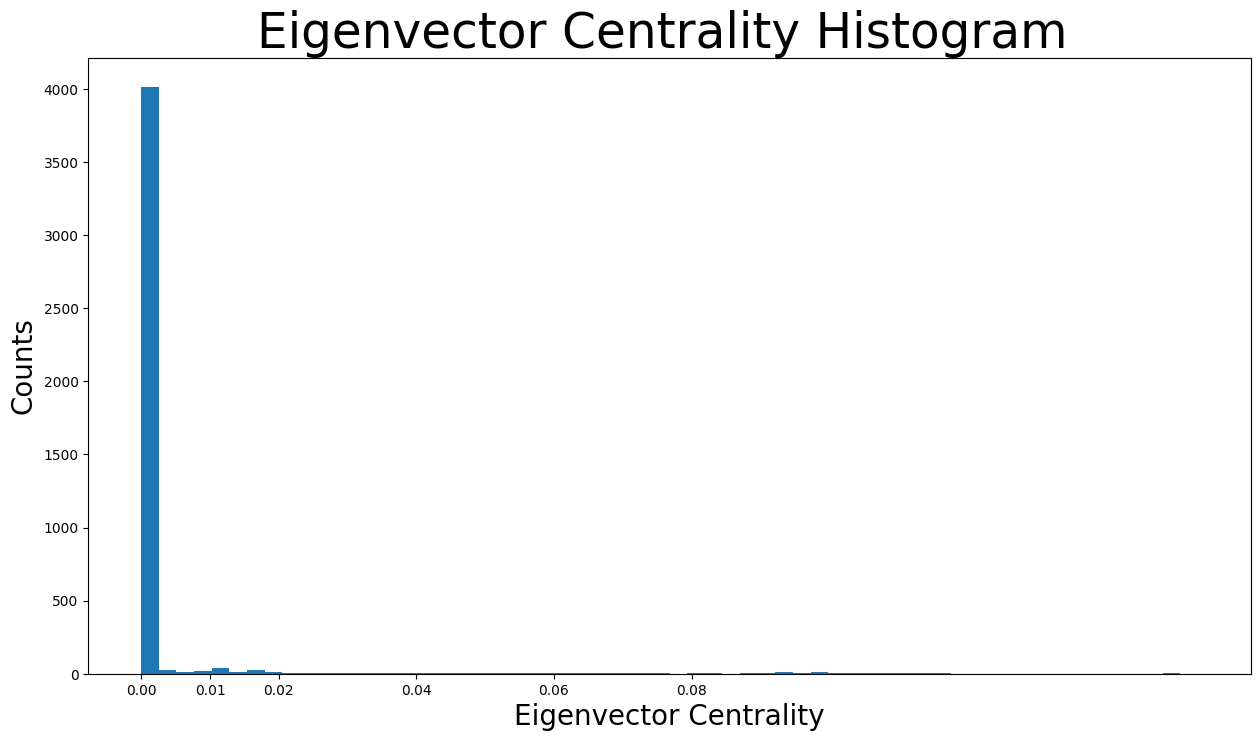

In [13]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # set the x axis ticks
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

As shown in the distribution histogram, the vast majority of eigenvector centralities are below $0.02$ and are actually almost $0$. However, we can also see different values of eigenvector centralities as there are tiny bins all over the x axis.

Now we can identify the eigenvector centralities of nodes based on their size in the following representation:

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

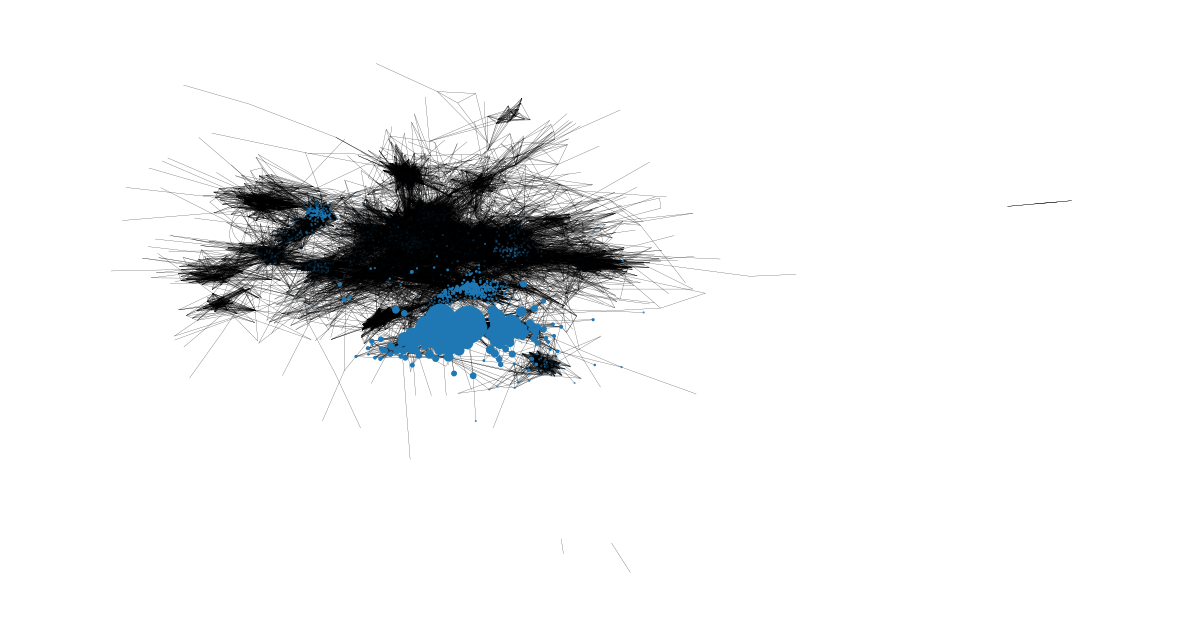

In [14]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Clustering Effects
The clustering coefficient of a node $v$ is defined as the probability that two randomly selected friends of $v$ are friends with each other. As a result, the average clustering coefficient is the average of clustering coefficients of all the nodes. The closer the average clustering coefficient is to $1$, the more complete the graph will be because there's just one giant component. Lastly, it is a sign of triadic closure because the more complete the graph is, the more triangles will usually arise.

In [15]:
nx.average_clustering(G)

0.4949716847236492

Now the clustering coefficient distribution will be displayed:

Text(0, 0.5, 'Counts')

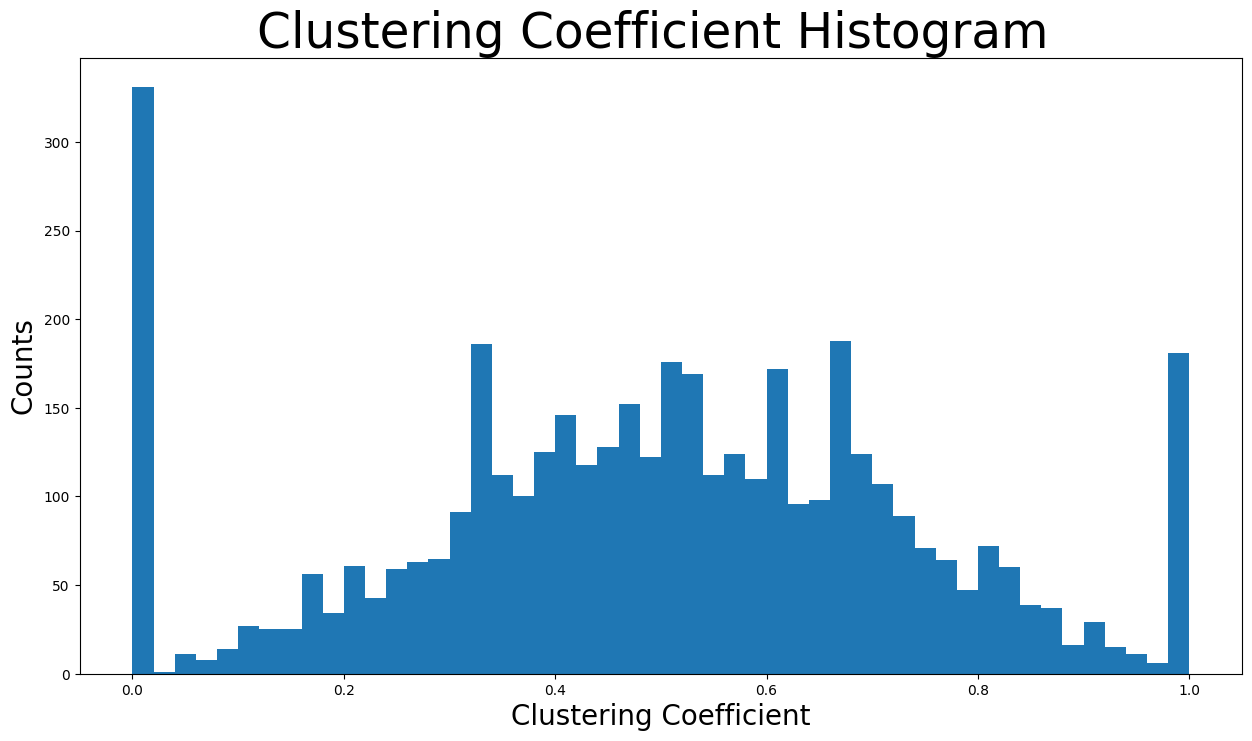

In [16]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

 $50$ bins were used to showcase the distribution. The bin with the highest counts concerns nodes with clustering coefficient close to $0$ as there are more than three-hundred nodes in that bin. In addition, the bins of clustering coefficient between $0.3$ and $0.7$ contain the majority of nodes by far.

 The number of unique triangles in the network are found next:

In [17]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3  # divide by 3 because each triangle is counted once for each node

465759.0

 Now the average number of triangles that a node is a part of:

In [18]:
np.mean(triangles_per_node)

323.7435125115848

Due to having some nodes that belong to a great many triangles, the metric of median will give us a better understanding:

In [19]:
np.median(triangles_per_node)

71.0

In fact, the median value is just $71$ triangles, when the mean is around $324$ triangles that a node is part of. That means that the in average the third part of nodes of the network belong to extremely few triangles, whereas some nodes are part of a plethora of triangles (which are extreme values that increase the mean)

## Bridges
First of all, an edge joining two nodes A and B in the graph is considered a bridge, if deleting the edge would cause A and B to lie in two different components. Now it is checked if there are any bridges in this network:

In [20]:
nx.has_bridges(G)

True

Actually, there are bridges in the network. Now the edges that are bridges will be saved in a list and the number of them is printed:

In [21]:
bridges = list(nx.bridges(G))
len(bridges)

209

The existence of so many bridges is due to the fact that this network only contains the spotlight nodes and the friends of them. As a result, some friends of spotlight nodes are only connected to a spotlight node, making that edge a bridge.

Also, the edges that are local bridges are saved in a list and their number is printed. In detaill, an edge joining two nodes $C$ and $D$
in a graph is a local bridge, if its endpoints $C$ and $D$ have no friends in common. Very importantly, an edge that is a bridge is also a local bridge. Thus, this list contains all the above bridges as well:

In [22]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

987

Showcasing the bridges and local bridges in the network now. The bridges can be seen with the red color and the local bridges with the green color. Black edges are neither local bridges nor bridges.

* It is clear that all the bridges concern nodes that are only connected to a spotlight node (have a degree of $1$)

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

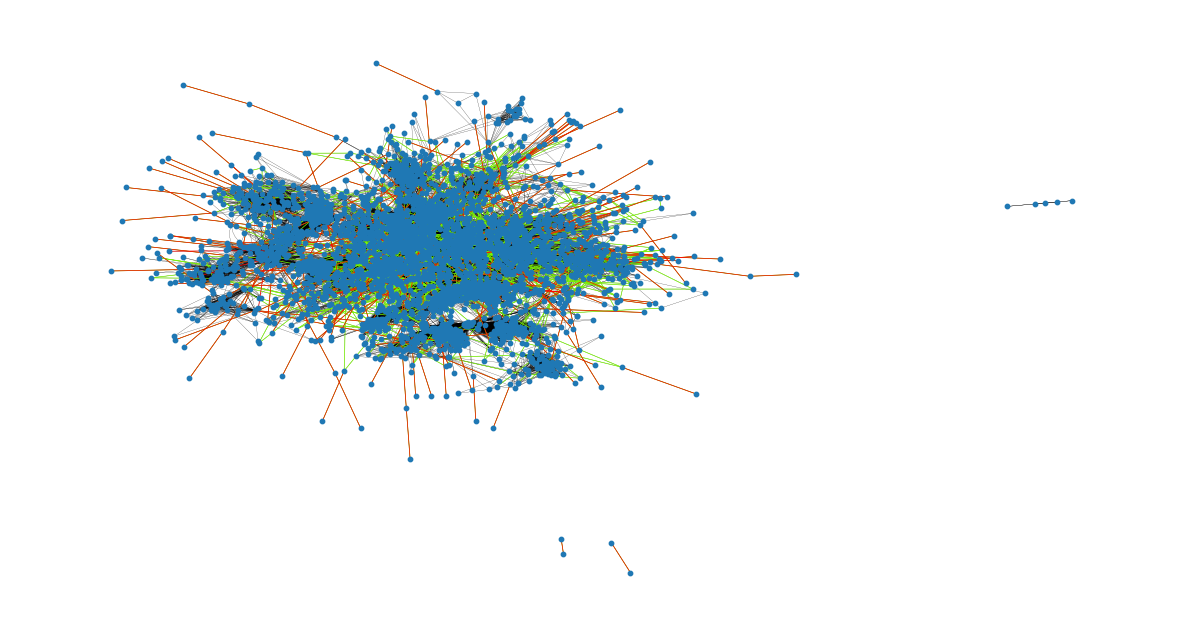

In [23]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

## Assortativity
Assortativity describes the preference for a network's nodes to attach to others that are similar in some way.
* The assortativity in terms of nodes degrees is found with two ways:

In [24]:
nx.degree_assortativity_coefficient(G)

0.07572773506976808

In [25]:
nx.degree_pearson_correlation_coefficient(
    G
)  # use the potentially faster scipy.stats.pearsonr function.

0.07572773506976584

In fact, the assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes. That means that it takes values from $-1$ to $1$. In detail, a positive assortativity coefficient indicates a correlation between nodes of similar degree, while a negative indicates correlation between nodes of different degrees.

In our case the assortativity coefficient is around $0.075$, which is almost 0. That means that the network is almost non-assortative, and we cannot correlate linked nodes based on their degrees. In other words, we can not draw conclusions on the number of friends of a user from his/her friends' number of friends (friends degree).

## Network Communities
A community is a group of nodes, so that nodes inside the group are connected with many more edges than between groups. Two different algorithms will be used for communities detection in this network

Firstly, a semi-synchronous label propagation method [^1] is used to detect the communities.

This function determines by itself the number of communities that will be detected. Now the communities will be iterated through and a colors list will be created to contain the same color for nodes that belong to the same community. Also, the number of communities is printed:

In [27]:
colors = {}  # diccionario para almacenar el color de cada nodo
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # genera un color RGB aleatorio
    counter += 1
    for node in com:  # asigna el color al nodo en el diccionario
        colors[node] = color
print(counter)

88


In detail, $88$ communities were detected. Now the communities are showcased in the graph. Each community is depicted with a different color and its nodes are usually located close to each other:

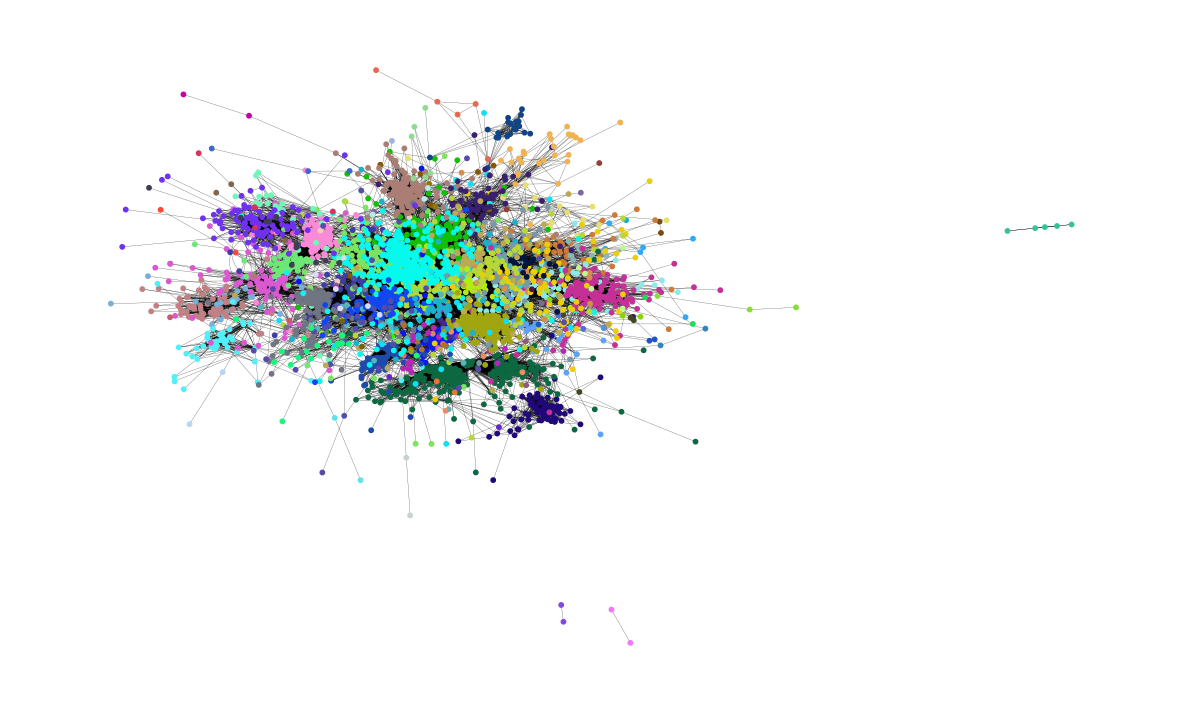

In [31]:
color_list = [colors[node] for node in G.nodes()]

plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=color_list
)

* Next, the asynchronous fluid communities algorithm [^2] is used.

With this function, we can decide the number of communities to be detected. Let's say that $8$ communities is the number we want. Again, the communities will be iterated through and a colors list will be created to contain the same color for nodes that belong to the same community.

Working with the bigger component

In [34]:
# Encontrar la componente más grande
largest_cc = max(nx.connected_components(G), key=len)
# Crear un subgrafo de la componente más grande
G_largest = G.subgraph(largest_cc)

colors = {}  # Diccionario para almacenar el color de cada nodo en el subgrafo
for com in nx.community.asyn_fluidc(G_largest, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # Generar color aleatorio
    for node in com:
        colors[node] = color  # Asignar el color a cada nodo en el diccionario

Now the $8$ communities are shown in the graph. Again, each community is depicted with a different color:

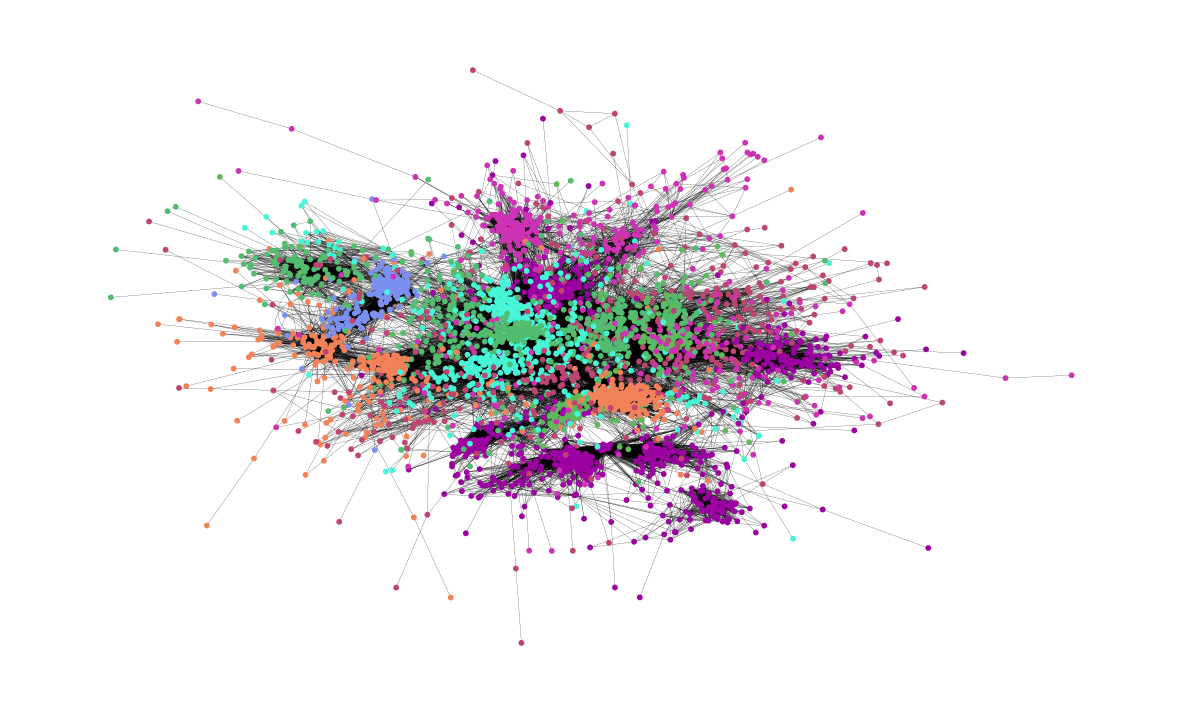

In [36]:
color_list = [colors[node] for node in G_largest.nodes()]

plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G_largest, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=color_list
)

## References

[^1]: [Semi-synchronous label propagation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html#networkx.algorithms.community.label_propagation.label_propagation_communities)

[^2]: [Asynchronous fluid communities algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.asyn_fluid.asyn_fluidc.html#networkx.algorithms.community.asyn_fluid.asyn_fluidc)

[Cambridge-intelligence](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/#:~:text=Centrality%20measures%20are%20a%20vital,but%20they%20all%20work%20differently.)